# EXERCISE 5.1: Land-Use-Land-Cover Pipeline using Sentinel Hub 

---

**Use of Sentinal Hub via API (sentinelhub-py) with Rwandan geodata to:**
* a) Extract an AOI from a larger dataset
* b) Apply cloud masking 
* c) Apply imputation (e.g. temporal interpolation)

This notebook consists of preliminary steps for data accessing and exploration towards constructing a machine learning pipeline for predicting the land use and land cover for the region of interest. We will use satellite images obtained by ESA's Sentinel-2 through the whole process of creating the pipeline, with details provided at each step. The actual model training will take place in the next module.


## Before you start

### Requirements

In order to run the example you'll need a Sentinel Hub account. If you do not have one yet, you can create a free trial account at [Sentinel Hub webpage](https://www.sentinel-hub.com/trial). If you are a researcher you can even apply for a free non-commercial account at [ESA OSEO page](https://earth.esa.int/aos/OSEO).

Once you have the account set up, please configure the `sentinelhub` package's configuration file following the [configuration instructions](http://sentinelhub-py.readthedocs.io/en/latest/configure.html). For Processing API request you need to obtain and set your `oauth` client id and secret. Also you can find this [guide ](https://docs.sentinel-hub.com/api/latest/user-guides/beginners-guide/)useful. 

### Overview


1. Define the Area-of-Interest (AOI):
   * Obtain the outline of AOI
   * Split into manageable smaller tiles

2. Use the integrated [sentinelhub-py](https://github.com/sentinel-hub/sentinelhub-py) package in order to fill the EOPatches with some content (band data, cloud masks, ...)
   * Define the time interval


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We install dependencies by clooning the eo-learn github repository and do the same to the matplotlib. The later causes the problem with the other libraries from eo-learn and to solve that, we install it from its repository

In [ ]:
#Install dependencies/libraries
!apt-get install gcc libgdal-dev graphviz proj-bin libproj-dev libspatialindex-dev
!pip install git+https://github.com/sentinel-hub/eo-learn.git
#!pip install git+https://github.com/matplotlib/matplotlib.git
!pip install aenum
!pip install geopandas
!pip install sentinelhub


Reading package lists... Done
Building dependency tree       
Reading state information... Done
gcc is already the newest version (4:9.3.0-1ubuntu2).
graphviz is already the newest version (2.42.2-3build2).
libspatialindex-dev is already the newest version (1.9.3-1build1).
libgdal-dev is already the newest version (3.3.2+dfsg-2~focal2).
libproj-dev is already the newest version (7.2.1-1~focal0).
proj-bin is already the newest version (7.2.1-1~focal0).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/sentinel-hub/eo-learn.git to /tmp/pip-req-build-ipww2b48
  Running command git clone --filter=blob:none --quiet https://github.com/sentinel-hub/eo-learn.git /tmp/pip-req-build-ipww2b48
  Resolved https://github.com/sentinel-hub/eo-learn.git to commit c4d0ddd7a857cdf13fcd8fdd05c749a636c61840
  Installing build dependencies ... done
  Getting requireme

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install eo-learn-core
!pip install eo-learn-coregistration
!pip install eo-learn-features
!pip install eo-learn-geometry
!pip install eo-learn-io
!pip install eo-learn-mask
!pip install eo-learn-ml-tools
!pip install eo-learn-visualization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Firstly, some necessary imports

# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
#%matplotlib inline

import datetime
import itertools

# Built-in modules
import os

# Basics of Python data handling and visualization
import numpy as np
from aenum import MultiValueEnum

np.random.seed(42)
import geopandas as gpd
import joblib
import matplotlib
import matplotlib.pyplot as plt
import getpass
# Machine learning
import lightgbm as lgb
#import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap
from shapely.geometry import Polygon
from sklearn import metrics, preprocessing
from tqdm.auto import tqdm


# Imports from eo-learn and sentinelhub-py
import eolearn
from sentinelhub import DataCollection, UtmZoneSplitter
from eolearn.core import (
    EOExecutor,
    EOPatch,
    EOTask,
    EOWorkflow,
    FeatureType,
    LoadTask,
    MergeFeatureTask,
    OverwritePermission,
    SaveTask,
    linearly_connect_tasks,
)
from eolearn.geometry import ErosionTask, VectorToRasterTask
from eolearn.io import ExportToTiffTask, SentinelHubInputTask, VectorImportTask
from eolearn.ml_tools import FractionSamplingTask

# Part 1

## 1. Define the Area-of-Interest (AOI):

* A geographical shape of an area in Rwanda was taken from [The World Bank data catalog](https://datacatalog.worldbank.org/search/dataset/0041453). The shape covers districts in Eastern province and is available in repository: `...Exercise_01/districts_east.geojson`
* TheCRS of our geographic AOI is the central UTM tile (UTM_36S)
* Split it into smaller, manageable, non-overlapping rectangular tiles
* Run classification on a selected 5x5 area

Be sure that your choice of CRS is the same as the CRS of your reference data.


Get the area of interest (AOI)

The code below load our AOI and read it. We add the buffer of 500m to make sure that when we split the AOI in patches (small area), all the AOI is fully covered.

Dimension of the area is 93382 x 152764 m2


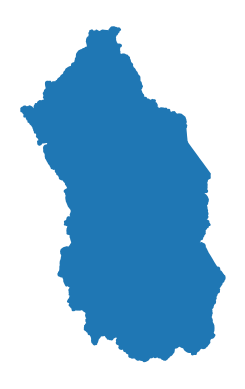

In [ ]:
# Set the file path
file_path = "/content/drive/MyDrive/ML4EO_M5/5_01_LULC_using_SentinelHub/districts_east.geojson"
# Load geojson file
rwanda_boundary = gpd.read_file(file_path)

# Add 500m buffer to secure sufficient data near border
rwanda_boundary = rwanda_boundary.buffer(distance=500)

# Get the country's shape in polygon format
rwanda_boundary_shape = rwanda_boundary.geometry.values[0]

# Plot country
rwanda_boundary.plot()
plt.axis("off")

# Print size
country_width = rwanda_boundary_shape.bounds[2] - rwanda_boundary_shape.bounds[0]
country_height = rwanda_boundary_shape.bounds[3] - rwanda_boundary_shape.bounds[1]
print(f"Dimension of the area is {country_width:.0f} x {country_height:.0f} m2")

### Split to smaller tiles and choose a 5x5 area
The area of interest (AOI) at a provincial level is too large and needs to be tiled into smaller pieces in order to be able to fit the one-year-long time series into memory (that more data). Each smaller piece is called an EOPatch in the eo-learn package. In order to create an EOPatch we simply need the bounding box in a given coordinate reference system. We'll use BBOXSplitter from sentinelhub python package.

Note: The splitting choice depends on the available resources of your computer. An EOPatch with a size of has around 500 x 500 pixels at 10 meter resolution has a size ob about ~1 GB.

In [ ]:
# Create a splitter to obtain a list of bboxes with 5km sides
bbox_splitter = UtmZoneSplitter([rwanda_boundary_shape], rwanda_boundary.crs, 5000)

bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())

# Prepare info of selected EOPatches
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list]
idxs = [info["index"] for info in info_list]
idxs_x = [info["index_x"] for info in info_list]
idxs_y = [info["index_y"] for info in info_list]

bbox_gdf = gpd.GeoDataFrame({"index": idxs, "index_x": idxs_x, "index_y": idxs_y}, crs=rwanda_boundary.crs, geometry=geometry)



/usr/local/lib/python3.9/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


In [ ]:
box_gdf = gpd.GeoDataFrame({"index": idxs, "index_x": idxs_x, "index_y": idxs_y}, crs=rwanda_boundary.crs, geometry=geometry)

# select a 5x5 area (id of center patch)
ID = 200

# Obtain surrounding 5x5 patches
patchIDs = []
for idx, (bbox, info) in enumerate(zip(bbox_list, info_list)):
    if abs(info["index_x"] - info_list[ID]["index_x"]) <= 2 and abs(info["index_y"] - info_list[ID]["index_y"]) <= 2:
        patchIDs.append(idx)

# Check if final size is 5x5
if len(patchIDs) != 5 * 5:
    print("Warning! Use a different central patch ID, this one is on the border.")

# Change the order of the patches (useful for plotting)
patchIDs = np.transpose(np.fliplr(np.array(patchIDs).reshape(5, 5))).ravel()



## Visualize the selection

## Question 5.1.1
Complete the code below to visualize the bbox created and those selected in the process above on tp of the shape of AOI.


In [ ]:
#Replace #<FILL-IN> with adequate codes

# Display bboxes over AOI
fig, ax = plt.subplots(figsize=(12, 16))
ax.set_title("Selected 5x5 tiles ", fontsize=15)
rwanda_boundary.plot(ax=ax, facecolor="w", edgecolor="r", alpha=1)
bbox_gdf.plot(ax=ax, facecolor="w", edgecolor="b", alpha=0.5)

for bbox, info in zip(bbox_list, info_list):
    #<FILL-IN> #Put your code here


# Mark bboxes of selected area
bbox_gdf[bbox_gdf.index.isin(patchIDs)].plot(ax=ax, facecolor="g", edgecolor="r", alpha=0.5)

plt.axis("Off");

In [ ]:
# Create a directory to store the EOPatches
EOPATCH_DIR = '/content/drive/MyDrive/ML4EO_M5/5_01_LULC_using_SentinelHub/EOPATCHES'
# Save to shapefile
shapefile_name = "grid.gpkg"
bbox_gdf.to_file(os.path.join(EOPATCH_DIR, shapefile_name), driver="GPKG")

# Part 2. Fill EOPatches with data using SentinelHub

Now it's time to create EOPatches and fill them with Sentinel-2 data using Sentinel Hub services. We will add the following data to each EOPatch:

* L1C custom list of bands [B02, B03, B04, B08, B11, B12], which corresponds to [B, G, R, NIR, SWIR1, SWIR2] wavelengths.

* SentinelHub's cloud mask

* A mask of validity, based on acquired data from Sentinel and cloud coverage. Valid pixel is if:
   
    1. IS_DATA == True
    2. CLOUD_MASK == 0 (1 indicates cloudy pixels and 255 indicates `NO_DATA`)

An EOPatch is created and manipulated using EOTasks, which are chained in an EOWorkflow. In this example the final workflow is executed on all patches, which are saved to the specified directory.

## Define some needed custom EOTasks

Here, we first set up our Sentinel Hub credentials using SHConfig. We then create a SentinelHubInputTask with the required parameters. Next, we define the bbox and time range for our SentinelHubRequest, and set up a SentinelHubDownloadClient. We then loop through each patch ID and load the EOPatch, set up the SentinelHubRequest, download the data to the EOPatch, and save the modified EOPatch.

In [ ]:


sh_params = {
    'sh_client_id': input("Enter your Sentinel Hub client ID: "),
    'sh_client_secret': getpass.getpass("Enter your Sentinel Hub client secret: ")
}

Enter your Sentinel Hub client ID: ee94fe32-423a-465f-b83c-1554e8b1d772
Enter your Sentinel Hub client secret: ··········


In the next code block, we are implementing imputation (using `SentinelHubValidDataTask`), which is  the process of filling in missing or incomplete data with estimated values based on the available data. It is a common technique used in data analysis and machine learning when dealing with datasets that contain missing values or incomplete observations.

Imputation by `SentinelHubValidDataTask` performs nearest neighbor whereby SentinelHubValidDataTask is used to retrieve a binary mask indicating which pixels in the data are valid. The binary mask is added to the EOPatch as a new mask with the name "IS_VALID". The binary mask has a value of 1 where the pixel is valid and a value of 0 where the pixel is invalid.

`AddValidCountTask` is used to count the number of valid observations per pixel using the "IS_VALID" mask. The task adds a new scalar feature to the EOPatch with the name "VALID_COUNT" that contains the number of valid observations per pixel.

Here, we are using s2cloudless algorithm (accessed through  `SentinelHubValidDataTask`), which is a cloud masking algorithm for Sentinel-2 imagery developed by Sentinel Hub. It is designed to identify and mask out clouds, cloud shadows, and cirrus clouds from Sentinel-2 imagery to improve the quality of downstream analysis.

The s2cloudless algorithm produces two outputs: a binary cloud mask and a cloud probability map. The binary cloud mask is a raster layer where cloud pixels are assigned a value of 1 and all other pixels are assigned a value of 0. The cloud probability map is a raster layer where each pixel is assigned a probability value between 0 and 100, representing the likelihood that the pixel contains clouds.

The cloud mask and probability map can be used in different ways depending on the specific application. For example, the cloud mask can be used to mask out clouds from satellite imagery before performing image analysis or classification. The cloud probability map can be used to identify areas of high cloud cover or to estimate cloud cover percentages over a larger area.

In [ ]:
class SentinelHubValidDataTask(EOTask):
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is asumed to be found in eopatch.mask['CLM']
    """

    def __init__(self, output_feature):
        self.output_feature = output_feature

    def execute(self, eopatch):
        eopatch[self.output_feature] = eopatch.mask["IS_DATA"].astype(bool) & (~eopatch.mask["CLM"].astype(bool))
        return eopatch


class AddValidCountTask(EOTask):
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """

    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name

    def execute(self, eopatch):
        eopatch[FeatureType.MASK_TIMELESS, self.name] = np.count_nonzero(eopatch.mask[self.what], axis=0)
        return eopatch

In [ ]:
# BAND DATA
# Add a request for S2 bands.
# Here we also do a simple filter of cloudy scenes (on tile level).
# The s2cloudless masks and probabilities are requested via additional data.


band_names = ["B02", "B03", "B04", "B08", "B11", "B12"]
add_data = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, "BANDS"),
    bands=band_names,
    resolution=10,
    maxcc=0.8,
    time_difference=datetime.timedelta(minutes=120),
    data_collection=DataCollection.SENTINEL2_L1C,
    additional_data=[(FeatureType.MASK, "dataMask", "IS_DATA"), (FeatureType.MASK, "CLM"), (FeatureType.DATA, "CLP")],
    max_threads=5,
    config=sh_params
)



# VALIDITY MASK
# Validate pixels using SentinelHub's cloud detection mask and region of acquisition
add_sh_validmask = SentinelHubValidDataTask((FeatureType.MASK, "IS_VALID"))

# COUNTING VALID PIXELS
# Count the number of valid observations per pixel using valid data mask
add_valid_count = AddValidCountTask("IS_VALID", "VALID_COUNT")

# SAVING TO OUTPUT (if needed)
save = SaveTask(EOPATCH_DIR, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

### Define the pipeline

All the tasks that were defined so far create and fill the EOPatches. The tasks need to be put in some order and executed one by one. This can be achieved by manually executing the tasks, or more conveniently, defining an `EOWorkflow` which does this for you.

The following workflow is created and executed:

1. Create EOPatches with band and cloud data
4. Add mask of valid pixels 
5. Add scalar feature representing the count of valid pixels (imputation)
7. Save eopatches

An EOWorkflow can be linear or more complex, but it should be acyclic. Here we will use the linear case of the EOWorkflow, available as `LinearWorkflow`

## Define the workflow tasks

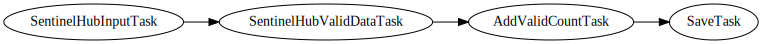

In [ ]:
# Define the workflow
workflow_nodes = linearly_connect_tasks(
    add_data, add_sh_validmask, add_valid_count, save
)
workflow = EOWorkflow(workflow_nodes)

# Let's visualize it
workflow.dependency_graph()

## Implement the workflow

Ensure that your SentinelHub credentials are correct and up-to-date. You can check your credentials by logging into the SentinelHub dashboard.
 

```
Attention:
```

**Insufficient account limits:** Make sure that your SentinelHub account has sufficient limits for the number of requests you are making. You can check your account limits by logging into the SentinelHub dashboard and navigating to the "Account" page.


The code section implement the above workflow step by step.
Note: This step takes time

MY SENTINELHUB ACCOUNT HAS LIMITED NUMBER OOF REQUEST. ASSUME IT IS THE SAME FOR OTHER PARTICIPANT ADVISE AS @MARK. COULD WE TRY A RESEARCHER ACCOUNT? I HAVE NOT TRIED IT. MAY BE ABRAHAM CAN ADVISE BASED ON PREVIOUS EXERCISES USING SENTINELPY API.



**Sharing Sentinel Hub authentication session required**

Since a user splits their area of interest into a large number of smaller bounding boxes. Then data download from Sentinel Hub need to be parallelized  over these bounding boxes using a few different Python processes. It depends on the type of parallelization, but without implementing a session sharing mechanism such a procedure could try to create a new authentication session for each small bounding box. In extreme cases that could fail because an excessive number of authentication requests might be rate-limited by Sentinel Hub.

In [ ]:
%%time

# Time interval for the SH request
time_interval = ["2022-01-01", "2022-12-31"]

# Define additional parameters of the workflow
input_node = workflow_nodes[0]
save_node = workflow_nodes[-1]
execution_args = []
for idx, bbox in enumerate(bbox_list[patchIDs]):
    execution_args.append(
        {
            input_node: {"bbox": bbox, "time_interval": time_interval},
            save_node: {"eopatch_folder": f"eopatch_{idx}"},
        }
    )

# Execute the workflow
executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=4)

executor.make_report()

failed_ids = executor.get_failed_executions()
if failed_ids:
    raise RuntimeError(
        f"Execution failed EOPatches with IDs:\n{failed_ids}\n"
        f"For more info check report at {executor.get_report_path()}"
    )

### Visualize the patches

In [ ]:
# Draw the RGB images
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

date = datetime.datetime(2019, 7, 1)

for i in tqdm(range(len(patchIDs))):
    eopatch_path = os.path.join(EOPATCH_DIR, f"eopatch_{i}")
    eopatch = EOPatch.load(eopatch_path, lazy_loading=True)

    dates = np.array([timestamp.replace(tzinfo=None) for timestamp in eopatch.timestamps])
    closest_date_id = np.argsort(abs(date - dates))[0]

    ax = axs[i // 5][i % 5]
    ax.imshow(np.clip(eopatch.data["BANDS"][closest_date_id][..., [2, 1, 0]] * 3.5, 0, 1))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)